#Time stamp 14:00:00



### Common libraries

* torcchvision.datasest

* torchvision.models
* torchvision.transforms - function to manipulate visual data
* torch.utils.datasetss  - base datasets for pytorch
torch.utils.data.Dataloader - Creates python iterable for datasets

In [ ]:
import torch
from torch import nn

from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision import datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np


device = 'cuda' if torch.cuda.is_available() else "cpu"

#### ***Loading the fashion mnist data***


In [ ]:
from torchvision  import datasets

train_data = datasets.FashionMNIST(
    root = 'data',
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform = None
)

test_data = datasets.FashionMNIST(
    root = 'data',
    download = True,
    train = False,
    transform = ToTensor(),
    target_transform = None
)

100%|██████████| 26421880/26421880 [00:02<00:00, 10197537.95it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 170661.64it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3294428.10it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21506251.98it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
##### Setting the X and y

X_train = train_data.data
y_train = train_data.targets

X_test = test_data.data
y_test = test_data.targets

mapping_dict = train_data.class_to_idx
reverse_mapping_dict = {value : key for key , value in list(mapping_dict.items())}


In [ ]:
X_train[0].shape

torch.Size([28, 28])

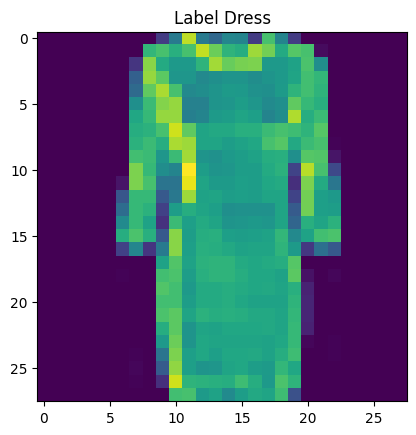

In [ ]:
index = int(torch.randint(1 , len(X_train) , (1,)))
plt.figure()
plt.title(f"Label {reverse_mapping_dict[int(y_train[index])]}")
plt.imshow(X_train[index] )
plt.show()



Cols 5  Rows 4 , 19


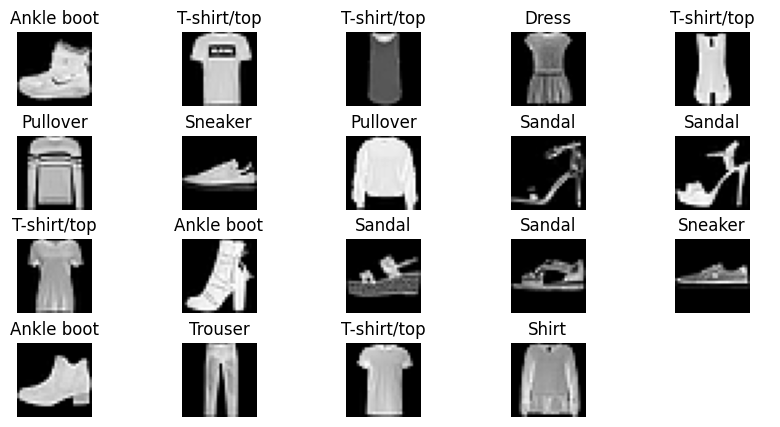

In [ ]:

import math

def plot(data ,  reverse_mapping_dict =  reverse_mapping_dict):

  cols = round(math.sqrt(len(data)))
  rows = math.ceil(len(data) / cols)

  cols_ = max(rows , cols)
  rows_ = min(rows , cols)
  print(f"Cols {cols_}  Rows {rows_} , {len(data)}")
  fig , axs = plt.subplots(rows_ , cols_ , figsize = (10 , 5))
  fig.subplots_adjust(wspace=0.4, hspace=0.4)

  taken = []

  for row in range( rows_ ):
    for col in range( cols_ ):
      img_idx = row * cols_ + col
      if img_idx < len(data):
        image = data[img_idx][0]
        image = image.squeeze()
        img_key = int(data[img_idx][1])
        label = reverse_mapping_dict[img_key]

        axs[row , col].imshow( image, cmap = 'gray')
        axs[row , col].axis("off")
        axs[row , col].set_title(label)
      else:
        axs[row , col].axis("off")


  return fig

data = list(zip(train_data.data , train_data.targets))
plot(data[0:19]).savefig('imge3.png')


In [ ]:
for l , i in data[:10]:
  # print(l)
  print(i, reverse_mapping_dict[int(i)])



tensor(9) Ankle boot
tensor(0) T-shirt/top
tensor(0) T-shirt/top
tensor(3) Dress
tensor(0) T-shirt/top
tensor(2) Pullover
tensor(7) Sneaker
tensor(2) Pullover
tensor(5) Sandal
tensor(5) Sandal


### ***Preparing the data Loader***

* This is done by a dataloader which breakes down  the images to a certain batch

* This maages memroy usage
* Gives the net more chances for looking the data


In [ ]:
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data ,
                              batch_size = BATCH_SIZE ,
                              shuffle = True )

test_dataloader = DataLoader(test_data ,
                             batch_size = BATCH_SIZE)


### ***Model 0: Build Model***

* Its always better to start with a simple model then increase  complexity as you proceed

* all `nn.models` can be used as models on their own

In [ ]:
## Faltten layer

flatten_model = nn.Flatten()

In [ ]:
image_1 , label = next(iter(train_dataloader))

In [ ]:
### creating the model

class FashionMnist(nn.Module):

    def __init__(self , input_shape ,hidden_units ,output_shape):
      super().__init__()

      self.layer_stack = nn.Sequential (nn.Flatten(),
                                        nn.Linear(input_shape , hidden_units),
                                        nn.Linear(hidden_units , output_shape)
                                        )

    def forward(self , X):
      return self.layer_stack(X)


In [ ]:
model_0 = FashionMnist(784 , 10 , len(train_data.classes)).to(device)
list(model_0.parameters())[0].device

device(type='cuda', index=0)

### ***Setting upp loss_fn and optimizer***

Data is multiclass hence

*   loss_fn =`nn.CrossEntropyLoss()`
*   optimizer = `torch.optim.SGD()`
*   Evaluation =  accurracy

In [ ]:
! wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py

--2024-03-10 12:39:42--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10160 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.92K  --.-KB/s    in 0s      

2024-03-10 12:39:43 (85.6 MB/s) - ‘helper_functions.py’ saved [10160/10160]



In [ ]:
from helper_functions import accuracy_fn
from timeit import default_timer as timer

## for progress bar we import tqdm

from tqdm.auto import  tqdm

In [ ]:


## loss fn and optims
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD( params = model_0.parameters(),lr = 0.1)


In [ ]:
 ## Training loop and on batches

EPOCHS = 3

for epoch in tqdm(range(EPOCHS)):
    batch_loss = 0
    for batch , (X, y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device)
        model_0.train()

        # 1 foward pass
        y_pred = model_0(X)

        # 2 loss
        loss = loss_fn(y_pred , y)
        batch_loss += loss

        # 3 optim
        optim.zero_grad()

        # 4 loss backward
        loss.backward()

        # 5 optimizer step
        optim.step()

        if batch % 400 == 0:
          print(f"Looked at  {batch* len(X)} / {len(train_dataloader.dataset) } samples")


    ### avergae the total loss
    batch_loss = batch_loss / len(train_dataloader)

    ## Evauation

    model_0.eval()
    test_loss = 0
    test_acc = 0
    with torch.inference_mode():
      # NB. Both test and acc are cumulative and need to be averaged
      for X_test , y_test in test_dataloader:
        # 1. Forward pass
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        test_pred = model_0(X_test)

        # 2. Test loss
        test_loss += loss_fn(test_pred , y_test)

        # 3. Test acc
        test_acc += accuracy_fn(y_true = y_test , y_pred = test_pred.argmax(dim = 1))

      # Average the metrics

      av_acc = test_acc/len(test_dataloader)
      av_loss = test_loss/len(test_dataloader)

    print("=="*10)
    print(f"Train Loss {batch_loss} | Test Loss  {av_loss} | Test acc {av_acc}")
    print("=="*10)





  0%|          | 0/3 [00:00<?, ?it/s]

Looked at  0 / 60000 samples
Looked at  12800 / 60000 samples
Looked at  25600 / 60000 samples
Looked at  38400 / 60000 samples
Looked at  51200 / 60000 samples
Train Loss 2.34684681892395 | Test Loss  2.3480916023254395 | Test acc 6.849041533546326
Looked at  0 / 60000 samples
Looked at  12800 / 60000 samples
Looked at  25600 / 60000 samples
Looked at  38400 / 60000 samples
Looked at  51200 / 60000 samples
Train Loss 2.3468427658081055 | Test Loss  2.3480916023254395 | Test acc 6.849041533546326
Looked at  0 / 60000 samples
Looked at  12800 / 60000 samples
Looked at  25600 / 60000 samples
Looked at  38400 / 60000 samples
Looked at  51200 / 60000 samples
Train Loss 2.34684157371521 | Test Loss  2.3480916023254395 | Test acc 6.849041533546326


### ***Making predictions and getting results***



In [ ]:
! pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 18.6 MB/s eta 0:00:00


In [ ]:
from torchmetrics.classification import MulticlassAUROC  , MulticlassConfusionMatrix , MulticlassPrecision , MulticlassRecall , MulticlassF1Score
from sklearn.metrics import classification_report
from timeit import default_timer as timer

def eval_model(model:torch.nn.Module ,
               dataloader : torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               accuracy_fn,
               num_classes,
               model_name = None ,
               full_report = False,
               device = None):


  """
    Evaluate the performance of a PyTorch model on a given dataset.

    Args:
    - model (torch.nn.Module): The PyTorch model to evaluate.
    - dataloader (torch.utils.data.DataLoader): DataLoader containing the evaluation dataset.
    - loss_fn (torch.nn.Module): Loss function used for evaluation.
    - accuracy_fn: Function to calculate accuracy.
    - num_classes (int): Number of classes in the classification task.
    - model_name (str, optional): Name of the model. Default is None.
    - full_report (bool, optional): Whether to return a detailed report for each batch. Default is False.
    - device 'cpu' / 'cuda'

    Returns:
    - dict or dict of dicts: Evaluation results. If full_report is False, returns a dictionary with average metrics.
      If full_report is True, returns a dictionary containing lists of metrics for each batch, along with average metrics.

  """

  if device == None:
    device = "cuda" if torch.cuda.is_available() else "cpu"

  model.to(device)
  model_eval = {
      "NAME":model_name,
      "auroc":[],
      "report":[],
      "Matrix":[],
      "accuracy":[],
      "loss":[],
      "f1_score":[],
      "recall":[],
      "precision":[],
      "inference_time":[]
  }



  with torch.inference_mode():
    accuracy , loss = 0 , 0
    for (X_test , y_test)  in tqdm(dataloader):

        X_test = X_test.to(device)
        y_test = y_test.to(device)

        start = timer()

        test_pred = model(X_test)

        end = timer()
        duration = end - start

        pred_probs = torch.softmax(test_pred , dim = 1)

        current_loss =  loss_fn(test_pred , y_test)
        loss +=current_loss

        current_accuracy = accuracy_fn(y_test ,test_pred.argmax(dim = 1))
        accuracy += current_accuracy

        auroc = MulticlassAUROC(num_classes)
        Precision = MulticlassPrecision(num_classes)
        Recall = MulticlassRecall(num_classes)
        F1_score  = MulticlassF1Score(num_classes)


        ### Transfering the pred probs to cpu for evaluation
        if device == 'cuda':
          pred_probs = pred_probs.to('cpu')
          y_test = y_test.to("cpu")
          test_pred = test_pred.to("cpu")

        auroc_score  = auroc( torch.softmax(test_pred , dim = 1) , y_test)
        f1_score = F1_score(pred_probs , y_test)
        recall_score = Recall(pred_probs , y_test )
        precision_score = Precision(pred_probs , y_test)

        report = classification_report(y_test,test_pred.argmax(dim = 1))

        conf_matrix = MulticlassConfusionMatrix(num_classes)
        conf_m = conf_matrix(pred_probs , y_test)

        model_eval["auroc"].append(auroc_score)
        model_eval['precision'].append(precision_score)
        model_eval['recall'].append(recall_score)
        model_eval['f1_score'].append(f1_score)

        model_eval["report"].append(report)
        model_eval["Matrix"].append(conf_matrix)

        model_eval["accuracy"].append(current_accuracy)
        model_eval["loss"].append(current_loss)
        model_eval['inference_time'].append(duration)


    loss = float(loss/len(dataloader))
    accuracy = float(accuracy /len(dataloader))

    model_eval["AV_ACC"] = accuracy
    model_eval["AV_LOSS"] = loss

    average_recall = float(torch.tensor(model_eval['recall']).mean())
    average_precision = float(torch.tensor(model_eval['precision']).mean())
    average_f1 = float(torch.tensor(model_eval['f1_score']).mean())
    average_auroc = float(torch.tensor(model_eval['auroc']).mean())
    total_time = sum(model_eval['inference_time'])
    time_per_batch = float(torch.tensor(model_eval['inference_time']).mean())

    average_report = {
        "MODEL_NAME":model_name,
        "ACCURACY":accuracy,
        "LOSS":loss,
        "AUROC":average_auroc,
        "RECALL":average_recall,
        "F1_SCORE":average_f1,
        "PRECISION":average_precision,
        "TOTAL_TIME":total_time,
        "BATCH_TIME":time_per_batch
      }


  return model_eval if full_report else average_report

test_dataloader.classes = test_data.classes
model_0_results = eval_model(model_0 ,test_dataloader ,loss_fn ,accuracy_fn  , model_name = "Model_0" , num_classes = len(train_data.classes))


  0%|          | 0/313 [00:00<?, ?it/s]

pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/p

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/p

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and 

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and 

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and 

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/p

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and 

 cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/p

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/p

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and 

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score 

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/p

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/p

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and 

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and 

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score 

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/p

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score 

In [ ]:


with torch.inference_mode():

  X_test , y_test = list(test_dataloader)[0]
  start = timer()
  y_preds = model_0(X_test)

print(timer() - start)

0.00010814100005518412
0.0008804950002740952


In [ ]:
f = timer()
model_0.eval()
print(timer()- f)

0.0006588350006495602


In [ ]:
model_0_results

{'MODEL_NAME': 'Model_0',
 'ACCURACY': 6.849041533546326,
 'LOSS': 2.3480916023254395,
 'AUROC': 0.3904408812522888,
 'RECALL': 0.06906048953533173,
 'F1_SCORE': 0.030002932995557785,
 'PRECISION': 0.02175719663500786,
 'TOTAL_TIME': 0.0781856220003192,
 'BATCH_TIME': 0.00024979430600069463}

In [ ]:
from timeit import default_timer as timer
import time
start = timer()
time.sleep(3)
end = timer()
print(end - start)

3.002428769999824


### ***CREATING A MODEL WITH NON-LINEARITY***

* The training is done on gpu


In [ ]:

device = 'cuda' if torch.cuda.is_available() else "cpu"


class FashionMnist(nn.Module):

    def __init__(self ,input_shape , hidden_units , output_shape ):
      super().__init__()

      self.layer_stack = nn.Sequential(
          nn.Flatten(),
          nn.Linear(input_shape , hidden_units),
          nn.ReLU(),
          nn.Linear(hidden_units , output_shape),
          nn.ReLU()

        )
    def forward(self , X:torch.Tensor):
      return self.layer_stack(X)




In [ ]:


model_1 = FashionMnist(28*28 , 10 , len(train_data.classes)).to(device)

from copy import deepcopy
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params = model_1.parameters() , lr = 0.1)


def train_step(model:torch.nn.Module , data :torch.utils.data.DataLoader , optim,accuracy_fn = None , loss_fn = loss_fn ):

    """Returns train loss and accuracy"""

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    loss_  , accuracy  = 0 , 0

    for X , y  in tqdm(data):
        X = X.to(device)
        y = y.to(device)
        model.train()

        ## forward
        y_preds = model(X)

        ##loss
        loss = loss_fn(y_preds , y)
        loss_ +=loss

        if accuracy_fn != None:
            accuracy += accuracy_fn(y , y_preds.argmax(dim = 1))

        ## Optim zero
        optim.zero_grad()

        ## loss backwards
        loss.backward()

        ### optim step
        optim.step()

    return f"Train Loss {loss_ /len(data)} | Train Accuracy {accuracy /len(data)}"

    # return deepcopy(model2)



def test_step(model: torch.nn.Module , data: torch.utils.data.DataLoader , accuracy_fn , loss_fn  ):
    """Return test loss and accuracy"""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    model.to(device)

    loss , accuracy = 0 , 0
    with torch.inference_mode():

        for X , y in tqdm(data):
            X = X.to(device)
            y = y.to(device)

            y_pred = model(X)

            loss += loss_fn( y_pred , y)
            accuracy += accuracy_fn(y , y_pred.argmax(dim = 1))


        average_loss = loss  / len(data)
        average_acc = accuracy /len(data)

    return f"Test Loss {average_loss} | Test Accuracy {average_acc}"



for  i in range(3):

    text = train_step(
        model = model_1,
        data = train_dataloader ,
        optim = optim,
        loss_fn = loss_fn ,
        accuracy_fn = accuracy_fn,
    )

    text2 = test_step(model= model_1 ,
              data = test_dataloader ,
              accuracy_fn = accuracy_fn ,
              loss_fn = loss_fn)

    print(text + " || " + text2)




  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss 0.8390486836433411 | Train Accuracy 70.20166666666667 || Test Loss 0.6930150985717773 | Test Accuracy 74.95007987220447


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss 0.668725311756134 | Train Accuracy 75.54 || Test Loss 0.6841254234313965 | Test Accuracy 74.42092651757189


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss 0.6467897295951843 | Train Accuracy 76.22833333333334 || Test Loss 0.6435693502426147 | Test Accuracy 76.33785942492013


In [ ]:
model_1_results = eval_model(model_1 , test_dataloader , loss_fn , accuracy_fn , model_name = "Model_1" , num_classes = len(train_data.classes))

  0%|          | 0/313 [00:00<?, ?it/s]

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and 

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and 

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and 

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score 

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score 

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/p

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and 

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/p

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/p

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and 

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score 

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/p

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/p

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and 

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/p

### ***Working with Conv***

* CNN are used to find patterns in visual data

In [ ]:

class FashionCnn(nn.Module):

    def __init__(self , in_shape , hidden_units , out_shape):
        super().__init__()
        self.in_f = hidden_units * 7 * 7
        self.out_shape = out_shape
        self.flatten = nn.Flatten()
        self.conv_block_1=nn.Sequential(

          nn.Conv2d(in_channels = in_shape ,
                          out_channels = hidden_units ,
                          kernel_size = 3,
                          stride = 1 ,
                          padding = 1),
          nn.ReLU(),
          nn.Conv2d(in_channels = hidden_units ,
                   out_channels = hidden_units ,
                   kernel_size = 3,
                   padding = 1,
                   stride = 1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size =(2 , 2))
          )

        self.conv_block_2= nn.Sequential(
            nn.Conv2d(in_channels = hidden_units ,
                      out_channels = hidden_units ,
                      kernel_size = 3 ,
                      padding = 1,
                      stride = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units ,
                      out_channels = hidden_units ,
                      kernel_size = 3 ,
                      stride = 1  ,
                      padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = (2 , 2))
            )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = self.in_f  ,out_features =self.out_shape )
            )


    def forward(self , X):
        x = self.conv_block_1(X)
        # print(x.shape  , '1')

        x = self.conv_block_2(x)
        # print(x.shape , '2')

        x = self.classifier(x)
        return x


model_2  = FashionCnn( in_shape = 1 , out_shape = 10 , hidden_units = 10).to(device)

In [ ]:
model_2

FashionCnn(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

###  ***A walk Through***


In [ ]:
# dummy data from cnn explainer

torch.manual_seed(42)

images = torch.randn(size = (32 , 3 , 64 , 64))

In [ ]:
conv_layer  = torch.nn.Conv2d(3 ,10 , kernel_size = 3 , stride = 2 , padding = 0 )

In [ ]:
conv_layer

Conv2d(3, 10, kernel_size=(3, 3), stride=(2, 2))

In [ ]:
c = conv_layer(images[0])

In [ ]:
c.shape

torch.Size([10, 31, 31])

In [ ]:
image_link = "https://en.wikipedia.org/wiki/Image#/media/File:Image_created_with_a_mobile_phone.png"

import requests

req = requests.get("https://en.wikipedia.org/wiki/Image#/media/File:Image_created_with_a_mobile_phone.png")

In [ ]:
image = req.content

In [ ]:
import requests
from PIL import Image
from io import BytesIO

# URL of the image
url = "https://archive.org/download/2_20200505_20200505_0342/1.JPG"

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Read the content of the response
    image_data = response.content

    # Create a PIL Image object from the image data
    image = Image.open(BytesIO(image_data))
    image.save('cars.jpeg')

    # Display the image
    image.show()

else:
    print("Failed to download the image. Status code:", response.status_code)


In [ ]:
type(image)

PIL.JpegImagePlugin.JpegImageFile

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


image_arr = np.array(image).astype(np.float32)

In [ ]:
image_tensor = torch.from_numpy(image_arr).permute(2 , 0 , 1)
print(image_tensor.shape)

torch.Size([3, 2736, 3648])


### ***Playing Around with conv2d***

In [ ]:
conv_layer = torch.nn.Conv2d(in_channels=3 , out_channels=10 , kernel_size=(2 , 2) , stride=1)
conv_2 =nn.Conv2d(10 , 10 , 2 , 1 )

max_pool_l1 = nn.MaxPool2d(kernel_size =3)

conv_3 = nn.Conv2d(in_channels = 10 , out_channels = 1 , kernel_size = 2 , stride = 2 , padding = 1 )



### ***Training the model***

* set up the loss_fn -> `nn.CrossEntropyLoss`
* set optimizer      -> `nn.Optimizer.SGD`

In [ ]:
model_2= FashionCnn(in_shape = 1, hidden_units = 10 , out_shape = 10)

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params =model_2.parameters() , lr = 0.1)


epochs = 3

for epoch in tqdm(range(epochs)):

    text = train_step(model = model_2 ,
                      data = train_dataloader ,
                      optim = optim,
                      accuracy_fn = accuracy_fn ,
                      loss_fn = loss_fn)

    text_2 = test_step(model = model_2 ,
                       data = test_dataloader ,
                       accuracy_fn = accuracy_fn ,
                       loss_fn = loss_fn)

    print(f"{text} || {text_2}")






  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss 0.7268447279930115 | Train Accuracy 73.42166666666667 || Test Loss 0.3968757688999176 | Test Accuracy 85.8626198083067


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss 0.3562878668308258 | Train Accuracy 87.16833333333334 || Test Loss 0.3502921760082245 | Test Accuracy 87.34025559105432


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Train Loss 0.32021912932395935 | Train Accuracy 88.47166666666666 || Test Loss 0.3450169265270233 | Test Accuracy 87.83945686900958


In [ ]:
test_step

<function __main__.test_step(model: torch.nn.modules.module.Module, data: torch.utils.data.dataloader.DataLoader, accuracy_fn, loss_fn)>

In [ ]:
train_step

<function __main__.train_step(model: torch.nn.modules.module.Module, data: torch.utils.data.dataloader.DataLoader, optim, accuracy_fn=None, loss_fn=CrossEntropyLoss())>

In [ ]:

eval_model

<function __main__.eval_model(model: torch.nn.modules.module.Module, dataloader: torch.utils.data.dataloader.DataLoader, loss_fn: torch.nn.modules.module.Module, accuracy_fn, num_classes, model_name=None, full_report=False, device=None)>

## ***evaluating the model***

In [ ]:
model_2_results = eval_model(model_2 , test_dataloader ,
                     loss_fn = loss_fn ,
                     accuracy_fn = accuracy_fn , model_name = "Model_2" , num_classes = len(train_data.classes))

model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels 

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-def

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no tru

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/p

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-def

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-def

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no tru

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/p

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and 

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/p

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-def

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels 

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/p

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/p

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and 

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/p

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and 

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/p

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-def

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/p

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/p

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/p

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*ar

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-def

pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu
pred_probs cpu


/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-def

{'MODEL_NAME': 'Model_2',
 'ACCURACY': 87.83945686900958,
 'LOSS': 0.3450169265270233,
 'AUROC': 0.9553912878036499,
 'RECALL': 0.86896151304245,
 'F1_SCORE': 0.8524519801139832,
 'PRECISION': 0.8685392141342163,
 'TOTAL_TIME': 0.2622122509994824,
 'BATCH_TIME': 0.0008377388003282249}

### ***Comparison of MOdels perfomance***

* We will compare:

    - train and test loss
    - train and test accuracy
    - auroc

* The comparision is over each bacth

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame([model_0_results ,
                   model_1_results ,
                   model_2_results])

df

,MODEL_NAME,ACCURACY,LOSS,AUROC,RECALL,F1_SCORE,PRECISION,TOTAL_TIME,BATCH_TIME
0,Model_0,6.849042,2.348092,0.390441,0.069060,0.030003,0.021757,0.078186,0.000250
1,Model_1,76.337859,0.643569,0.946686,0.753465,0.706759,0.706545,0.072513,0.000232
2,Model_2,87.839457,0.345017,0.955391,0.868962,0.852452,0.868539,0.262212,0.000838


In [ ]:

### Making prediction

import random
test_images = []
for img , label in random.sample(test_data , k= 12):





TypeError: Population must be a sequence.  For dicts or sets, use sorted(d).

In [ ]:
train_data